# Import Libraries and Dataset

In [13]:
import pandas as pd
import quandl
import numpy as np
import quandl
import matplotlib.pyplot as plt
import os
import math
import talib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from sklearn.metrics import accuracy_score
import seaborn as sns
import operator
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(20, 8), dpi=100)
from datetime import datetime

In [31]:
os.chdir("//Users//abhishekmukherjee//Desktop//ProjectData_1")

#change the name of the stock to analyze earnings prediction for different stocks
stock_name = "GS"
data = pd.read_excel(stock_name + "_FinalData.xlsx")
print('Total dataset has {} days, and {} features.'.format(data.shape[0], \
                                                              data.shape[1]))
df = data.copy()
#df_clf = data.copy()
del df['Date']
del df['Earning_Surprise_0.05']
del df['Earning_Surprise_0.1']
del df['Earning_Surprise_0.15']

Total dataset has 4986 days, and 356 features.


In [15]:
df_clf = data.copy()
del df_clf['Date']

In [16]:
class Plot:
    
    def __init__(self, data):
        self.data = data
        
    def autocorr(self, col):
        
        plot_acf(data[col], title = col + ' Autocorrelation Plot')
        plt.show()
            
    def featureImportance(self, feature_importance, num_features, flag):
    
        f = dict()
        n = len(feature_importance)
        for i in range (n):
            f[X_test.columns[i]] = feature_importance[i]
        f = sorted(f.items(), key=operator.itemgetter(1), reverse=True)
        f = f[:num_features]
        feature_name = list()
        feature_values = list()
        for i, j in f:
            feature_name.append(i)
            feature_values.append(j)
        fig = plt.figure(figsize=(14,5))
        plt.xticks(rotation='vertical')
        plt.bar([i for i in range(len(f))], feature_values, tick_label=feature_name)
        if flag == 1:
            plt.title('Feature importance for EPS Prediction (Excluding Analyst estimate features)')
        else:
            plt.title('Feature importance for EPS Prediction (Including Analyst estimate features)')
        plt.show()
    
    def lossStatsAndCurve(self, X_test, Y_test, regressor):
        
        
        rmse = np.sqrt(mean_squared_error(Y_test, regressor.predict(X_test)))
        print("Root Mean Squared Error: %f" % (rmse))
        #print ("Regression Prediction Score: " + str(round(regressor.score(X_test,Y_test) * 100, 2)) + "%")
        eval_result = regressor.evals_result()
        training_rounds = range(len(eval_result['validation_0']['rmse']))
        plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
        plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title('Training Vs Validation Error')
        plt.legend()
        plt.show()

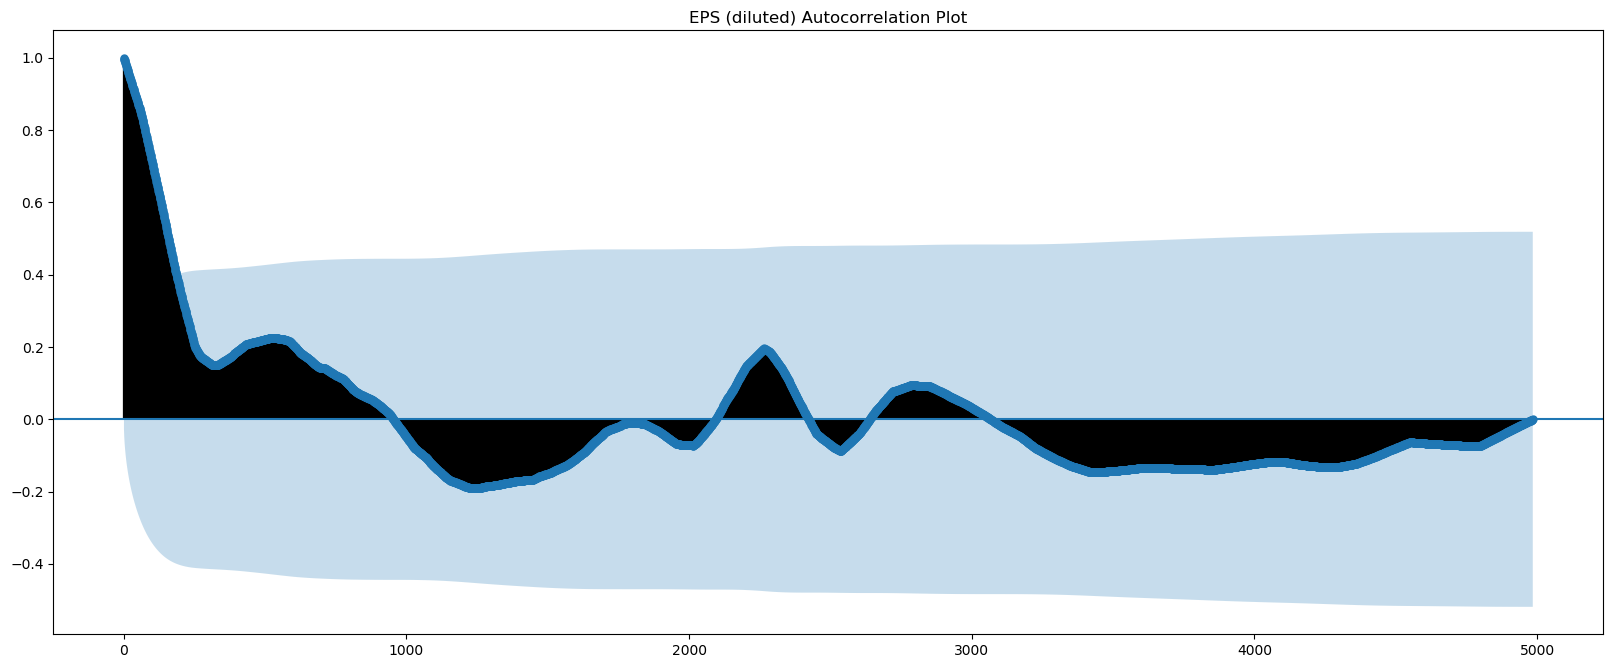

In [17]:
plot = Plot(data)
plot.autocorr('EPS (diluted)')

## Using XGBoost Method for EPS prediction (Regression Problem) and Feature Importance

In [18]:
class Model:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
    
    def trainModel(self, epoch = 1000, verbose_flag = False, learning_rate = 0.01):
        
        regressor = xgb.XGBRegressor(colsample_bytree = 0.4, learning_rate = learning_rate, base_score=0.65, max_depth = 4, alpha = 10, n_estimators = epoch)
        xgbModel=regressor.fit(X_train, Y_train,eval_set = [(X_train, Y_train), (X_test, Y_test)], verbose = verbose_flag)
        return (xgbModel, regressor)


In [19]:
def getData(data_temp, inc_analyst):
    
    data = data_temp.copy()
    Y = data['EPS (diluted)']
    
    del data['EPS (recurring)']
    del data['EPS (diluted)']
    
    if inc_analyst == False:
        del data['Growth (YoY%)_Analyst']
        del data['EPS_Analyst']
    X = data
    
    train_samples = int(X.shape[0] * 0.75)
     
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    Y_train = Y.iloc[:train_samples]
    Y_test = Y.iloc[train_samples:]
    
    
    return (X_train, Y_train), (X_test, Y_test)

## Including Analyst Data

[20:10:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean Squared Error: 3.334361


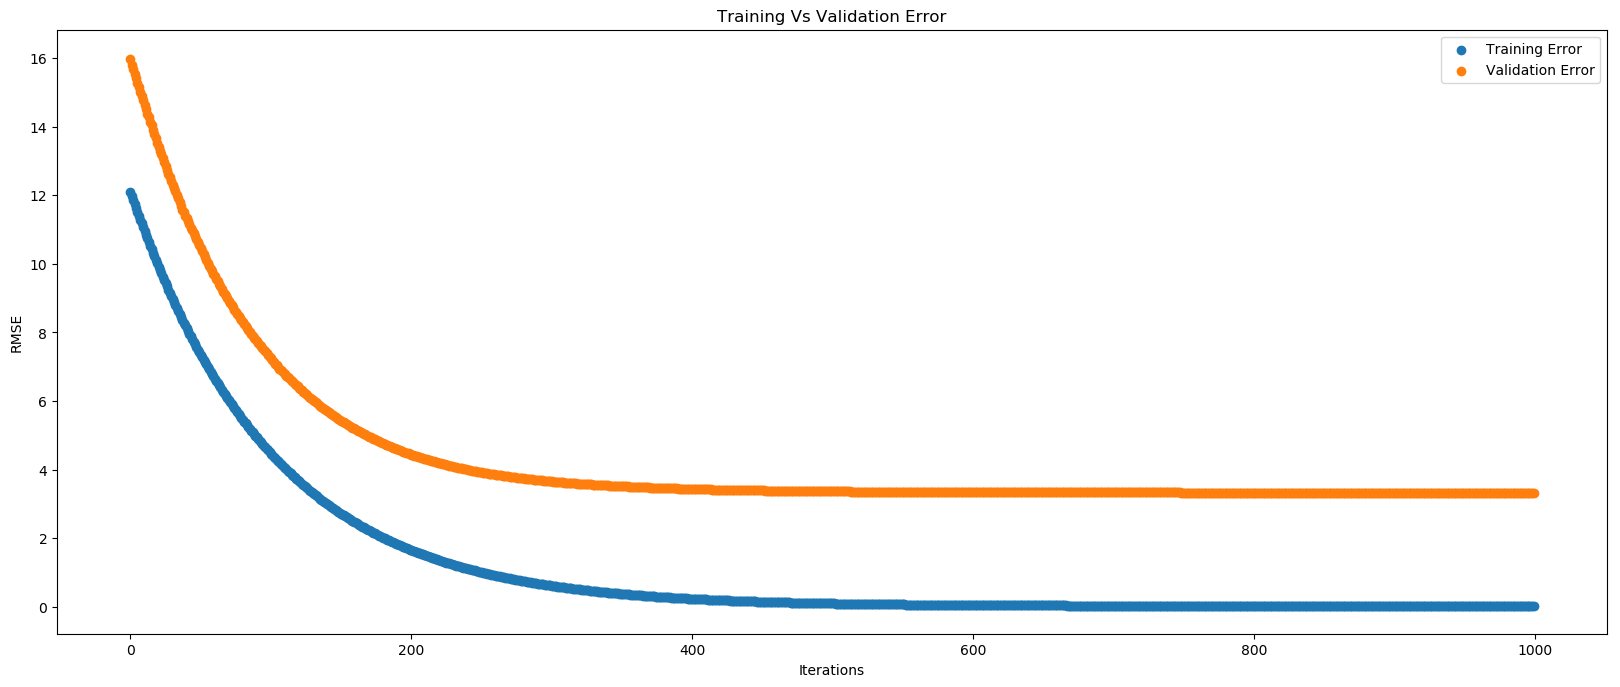

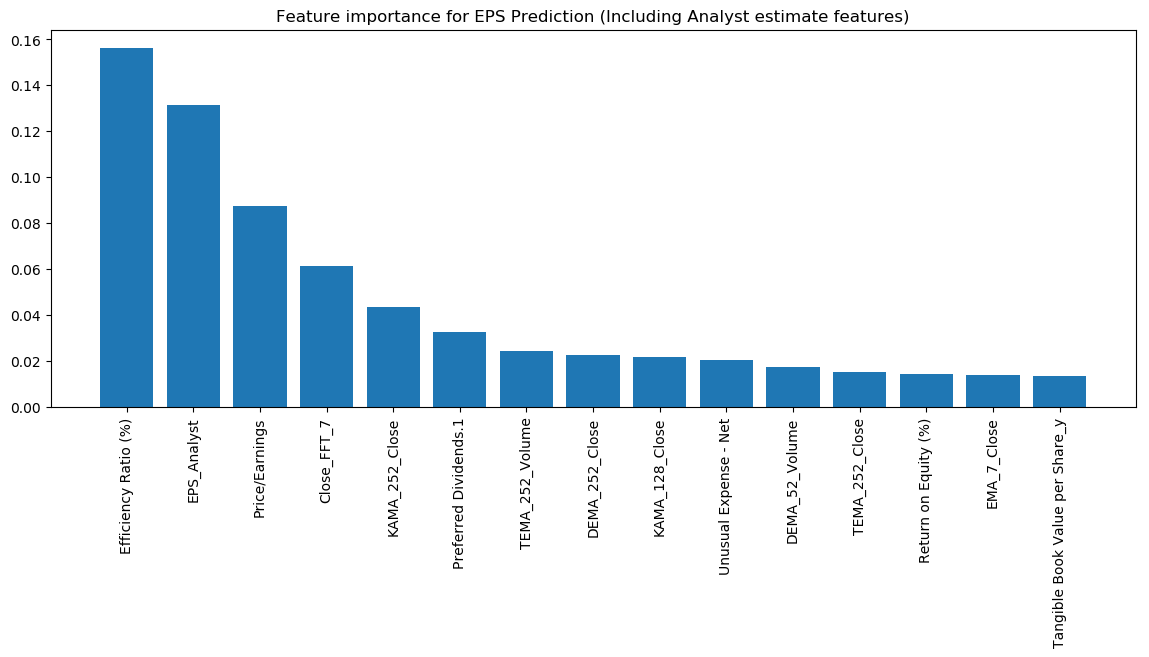

In [20]:

(X_train, Y_train), (X_test, Y_test) = getData(df, inc_analyst = True)

m1 = Model(X_train, Y_train ,X_test, Y_test)
xgbModel1, regressor1 = m1.trainModel()

plot.lossStatsAndCurve(X_test, Y_test, regressor1)
feature_importance = xgbModel1.feature_importances_.tolist()
plot.featureImportance(feature_importance, 15, 0)

## Excluding Analyst Data

[20:11:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean Squared Error: 3.423590


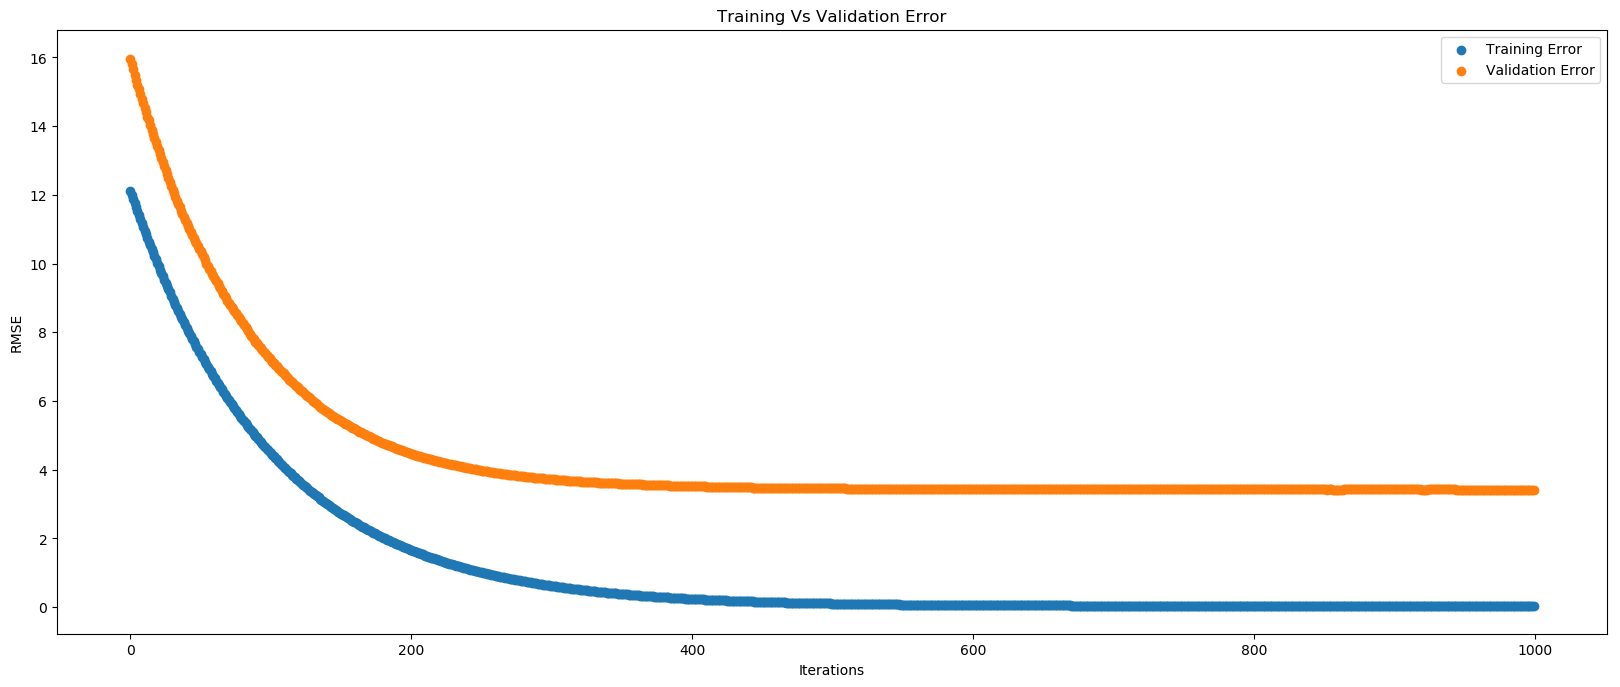

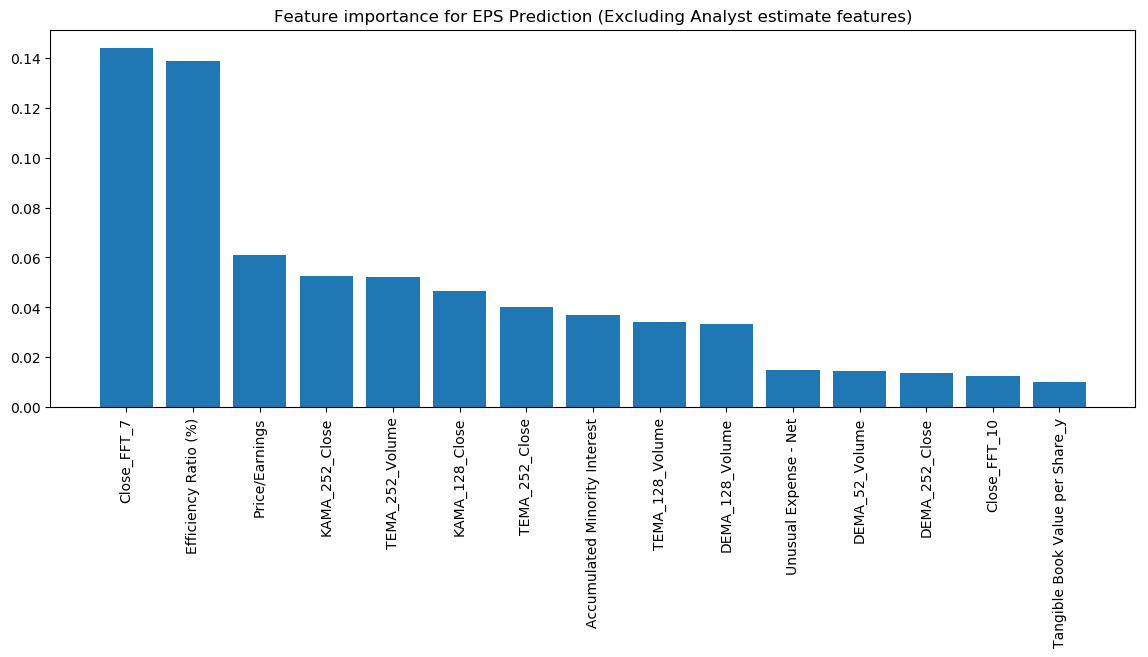

In [21]:
(X_train, Y_train), (X_test, Y_test) = getData(df, inc_analyst=False)
m2 = Model(X_train, Y_train, X_test, Y_test)
xgbModel2, regressor2 = m2.trainModel()
plot.lossStatsAndCurve(X_test, Y_test, regressor2)


feature_importance = xgbModel2.feature_importances_.tolist()
plot.featureImportance(feature_importance, 15, 1)

# Feature Reduction using XGBoost's feature importance

In [22]:
def featureReduction(feature_importance):
    
    f = dict()
    n = len(feature_importance)
    for i in range (n):
        f[X_test.columns[i]] = feature_importance[i]
    f = sorted(f.items(), key=operator.itemgetter(1), reverse=True)
    feature_name = list()
    feature_values = list()
    for i, j in f:
        feature_name.append(i)
        feature_values.append(j)
    
    return feature_name, feature_values
    

In [23]:
(X_train, Y_train), (X_test, Y_test) = getData(df, inc_analyst=True)
feature_importance = xgbModel1.feature_importances_.tolist()
feature_sorted, _ = featureReduction(feature_importance)
df_temp = df.copy()

n_features_to_keep = 30
for f in feature_sorted[n_features_to_keep:-1]:
    for col in df_temp.columns:
        if col == f:
            del df_temp[col]
            
df_temp.shape[1]

33

[20:17:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean Squared Error: 3.108390


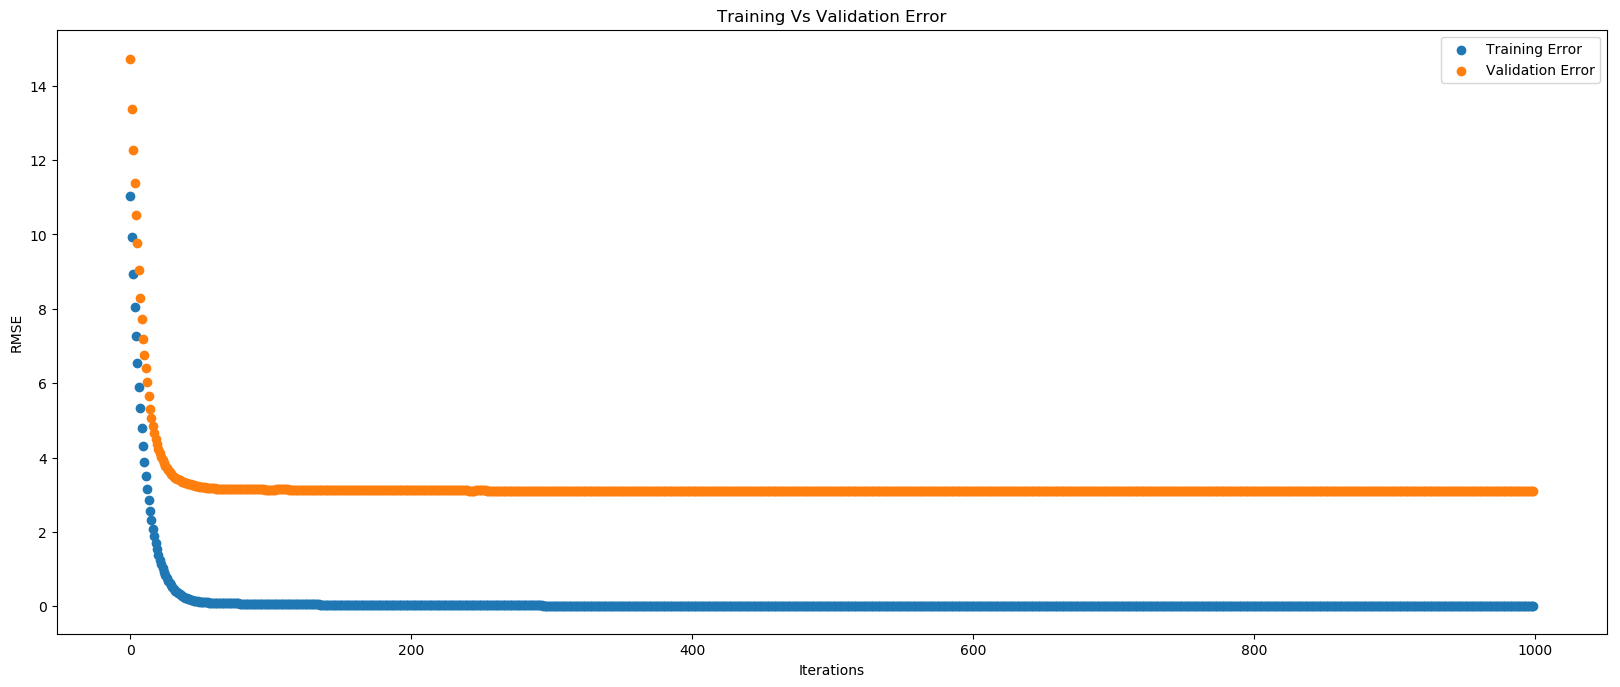

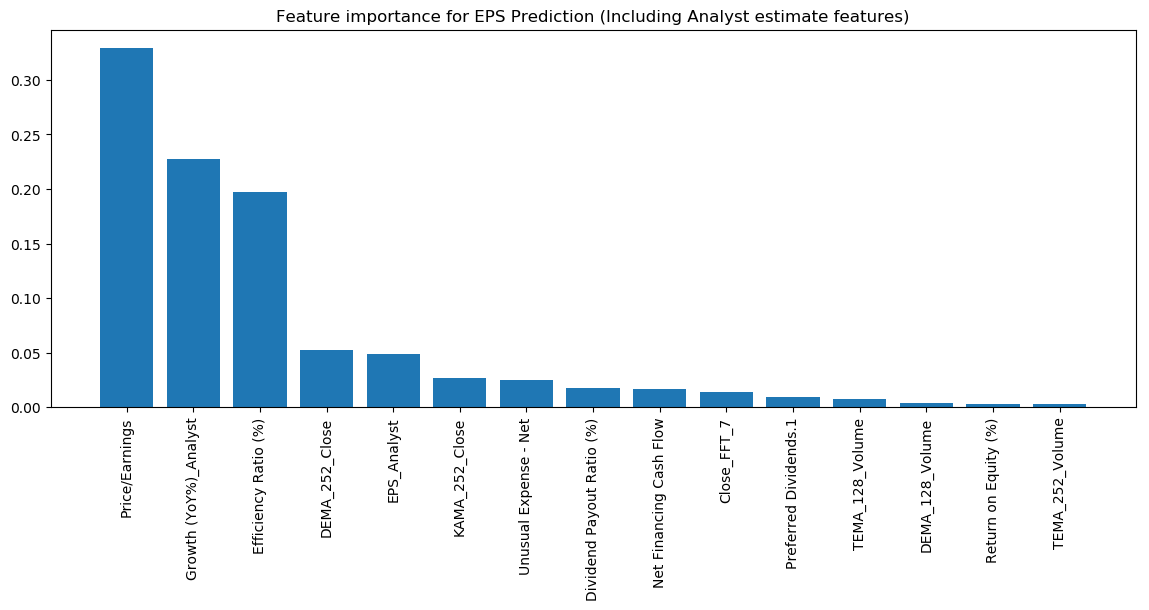

In [30]:
(X_train, Y_train), (X_test, Y_test) = getData(df_temp, inc_analyst=True)
m3 = Model(X_train, Y_train, X_test, Y_test)
xgbModel3, regressor3 = m3.trainModel(epoch = 1000, learning_rate = 0.1)
plot.lossStatsAndCurve(X_test, Y_test, regressor3)


feature_importance = xgbModel3.feature_importances_.tolist()
plot.featureImportance(feature_importance, 15, 0)

***Note: Keeping 33 most predictive features improves Model's prediction accuracy from 52.2% to 63.5% and reduces Root Mean Squared Error from 3.33 to 2.91 (Try playing with n_features_to_keep to improve the Model's predictive accuracy) Note: Keeping 20 high predictive features results Model's prediction accuracy 56.53%. Hence we can conclude that it is optimal to keep 33 most predictive features obtained from XGBoost's feature Importance***

***Note: Keeping EPS_Analyst feature improves our Model's predictive accuracy in both the Scenario which matches with out intuition***

# Using XGBoost for Earning Surprise Classification


In [26]:
def getDataClassification(data_temp):
    
    data = data_temp.copy()
    Y = data['Earning_Surprise_0.15']

    del data['Earning_Surprise_0.05']
    del data['Earning_Surprise_0.1']
    del data['Earning_Surprise_0.15']
    del data['EPS (diluted)']
    del data['EPS (recurring)']
    
    #del data['EPS_Analyst']
    #del data['Growth (YoY%)_Analyst']
    
    X = data
    train_samples = int(X.shape[0] * 0.5)
    
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    Y_train = Y.iloc[:train_samples]
    Y_test = Y.iloc[train_samples:]
    
    return X_train, Y_train, X_test, Y_test

In [27]:
X_train, Y_train, X_test, Y_test = getDataClassification(df_clf)
model = xgb.XGBClassifier()
model.fit(X_train, Y_train, verbose = True)
Y_pred = model.predict(X_test)
predictions = [round(value) for value in Y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.87%


In [28]:
print(classification_report(Y_test, predictions))
accuracy = accuracy_score(Y_test, predictions)
print ("Classifier Accuracy: ", accuracy)
cm = confusion_matrix(Y_test, predictions)
print ()
print ("Confusion Matrix:")
print (cm)

             precision    recall  f1-score   support

          0       0.96      1.00      0.98      2388
          1       1.00      0.05      0.09        43
          2       0.00      0.00      0.00        62

avg / total       0.94      0.96      0.94      2493

Classifier Accuracy:  0.9586843160850381

Confusion Matrix:
[[2388    0    0]
 [  41    2    0]
 [  62    0    0]]


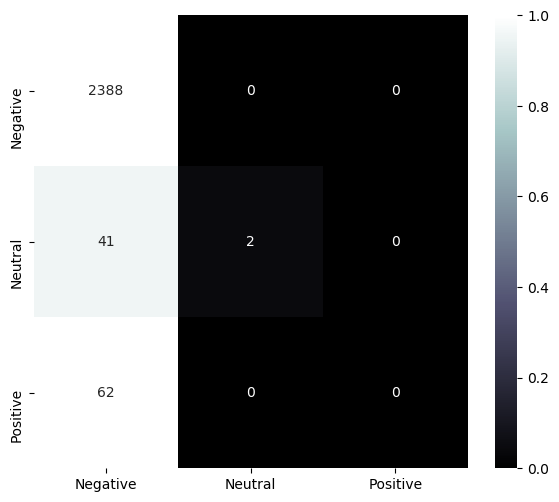

In [29]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        plt.savefig('confusion-matrix.png')

plot_confusion_matrix(cm, ['Negative', 'Neutral', 'Positive'])